# Sea surface temperature: outlook map
----

J. Potemra<br>
February 2024

----
This notebook will access sea surface temperature (SST) from the NOAA Climate Forecast CFSv2 model and produce maps of the mean SST departures from the current month.  The four panels show the difference in SST forecast for 8 months into the future.

The CFS version 2 was developed at the Environmental Modeling Center at NCEP. It is a fully coupled model representing the interaction between the Earth's atmosphere, oceans, land and seaice. It became operational at NCEP in March 2011.<sup>1</sup>

In this notebook the data are accessed from the NOAA NOMADS THREDDS server (https://www.ncei.noaa.gov/thredds/catalog/model/model.html).  The output is then found under Climate Forecast System --> CFS Operational 9-Month Forecast Monthly Mean --> then year, month day.  For example, for the nine month forecast from Feb 1, 2024:
https://www.ncei.noaa.gov/thredds/catalog/model-cfs_v2_for_mm/2024/202402/20240201/2024020100/catalog.html

The model is run every day and there are four initializations (at 00, 06, 12, 18 hours).  The files are stored in a TDS catalog within a directory structure by year, then year-month, then year-month-day, then year-month-day-forecast time.  So, for example, the run initialized at 00 on February 1, 2024 would be in a directory 2024/202402/20240201/2024020100.  The file acccessed then has the name ocnh.01.2024020100.202402.avrg.grib.grb2.  This is important as the file access can be scripted.  Here we use a set time, but this could be automatic based on run time.

-------
<sup>1</sup>Saha, Suranjana, and Coauthors, 2010: The NCEP Climate Forecast System Reanalysis. Bull. Amer. Meteor. Soc., 91, 1015.1057. doi: 10.1175/2010BAMS3001.1

## Import needed packages

In [1]:
# data I/O and processing
import xarray as xr
import pandas as pd
import numpy as np
import pickle

# data plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd

## Read data
The data are available on the NOAA THREDDS server.  Here we specify the date of run to access data.


In [2]:
# set the number of files to get and the interval; here we get four 
# separated by two months
num_files = 4
delta_file = 2

# set initial file by year, month, day
mod_year = '2024'
mod_mon = '02'
mod_day = '01'
mod_hour = '00'
root_url = 'https://www.ncei.noaa.gov/thredds/dodsC/model-cfs_v2_for_mm/'
subdir = mod_year + '/' + mod_year + mod_mon + '/' + mod_year + mod_mon + mod_day + '/' \
       + mod_year + mod_mon + mod_day + mod_hour + '/'

# define url's for OPeNDAP requests
url = []
for imon in range(num_files+1):
    filename = 'ocnh.01.' + mod_year + mod_mon + mod_day + mod_hour + '.' + mod_year \
             + str(imon*delta_file+delta_file).zfill(2) + '.avrg.grib.grb2'
    url.append(root_url+subdir+filename)

In [3]:
def get_remote(min_lon,max_lon,min_lat,max_lat):
    sst = []
    for imon in range(num_files+1):
        ds = xr.open_dataset(url[imon],decode_times=False)['Temperature_surface_1_Month_Average']
        D = ds.sel(lat = slice(min_lat,max_lat), lon = slice(min_lon,max_lon))
        if imon == 0:
            sst_ref = D
        elif imon == 1:
            sst = D - sst_ref
        else:
            sst = xr.concat([D-sst_ref,sst],dim='time')     
    return sst

## Define lat/lon/time ranges for analysis and display

In [4]:
# define lat/lon range for Palau
min_lat = 0.0
max_lat = 13.0
min_lon = 128.0
max_lon = 138.0

## Read data
Note the data is not read until "needed."  Data access may take a while since we're loading from a remote server. 

In [5]:
# do a remote OPeNDAP read
#ds = get_remote(min_lon,max_lon,min_lat,max_lat,min_year,max_year)
# do a local read
sst = get_remote(min_lon,max_lon,max_lat,min_lat)

# also read the EEZ as a shape file
shape_gpd = gpd.read_file('./data/pw_eez_line_april2022.shp')

## Make a plot
Here we define a couple functions to add fancy axes and maps/coastlines to our figures.  First we set some "global attributes" like the geographic extent of the maps, map projection, _etc._

In [6]:
# Plot parameters
# geographic range; Note here use the maximum extent of the data, but
# we could also do a smaller (clipped) or large (white space) region
lon_range = [min_lon, max_lon]
lat_range = [min_lat, max_lat]

# color range for shading (in degrees C)
color_min, color_max = -3.0, 3.0

# projection
crs = ccrs.PlateCarree()

In [7]:
# add alternating black and white bars to map axes
def add_zebra_frame(ax, lw=2, segment_length=0.5, crs=ccrs.PlateCarree()):
    # Get the current extent of the map
    left, right, bot, top = ax.get_extent(crs=crs)

    # Calculate the nearest 0 or 0.5 degree mark within the current extent
    left_start = left - left % segment_length
    bot_start = bot - bot % segment_length

    # Adjust the start if it does not align with the desired segment start
    if left % segment_length >= segment_length / 2:
        left_start += segment_length
    if bot % segment_length >= segment_length / 2:
        bot_start += segment_length

    # Extend the frame slightly beyond the map extent to ensure full coverage
    right_end = right + (segment_length - right % segment_length)
    top_end = top + (segment_length - top % segment_length)

    # Calculate the number of segments needed for each side
    num_segments_x = int(np.ceil((right_end - left_start) / segment_length))
    num_segments_y = int(np.ceil((top_end - bot_start) / segment_length))
    
    # Draw horizontal stripes at the top and bottom
    for i in range(num_segments_x):
        #color = 'black' if (left_start + i * segment_length) % (2 * segment_length) == 0 else 'white'
        color = 'black' if (i * segment_length) % (2 * segment_length) == 0 else 'white'
        start_x = left_start + i * segment_length
        end_x = start_x + segment_length
        ax.hlines([bot, top], start_x, end_x, colors=color, linewidth=lw, transform=crs)

    # Draw vertical stripes on the left and right
    for j in range(num_segments_y):
        #color = 'black' if (bot_start + j * segment_length) % (2 * segment_length) == 0 else 'white'
        color = 'black' if (j * segment_length) % (2 * segment_length) == 0 else 'white'
        start_y = bot_start + j * segment_length
        end_y = start_y + segment_length
        ax.vlines([left, right], start_y, end_y, colors=color, linewidth=lw, transform=crs)

# plot the land and coastlines
def plot_map(vmin, vmax, xlims, ylims):
    """
    Plot a map of the magnitude of sea level change.

    Parameters:
    vmin (float): Minimum value for the color scale.
    vmax (float): Maximum value for the color scale.
    xlims (tuple): Tuple of min and max values for the x-axis limits.
    ylims (tuple): Tuple of min and max values for the y-axis limits.

    Returns:
    fig (matplotlib.figure.Figure): The matplotlib figure object.
    ax (matplotlib.axes._subplots.AxesSubplot): The matplotlib axes object.
    crs (cartopy.crs.Projection): The cartopy projection object.
    cmap (matplotlib.colors.Colormap): The colormap used for the plot.
    """
    crs = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': crs})
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    palette = sns.color_palette("mako", as_cmap=True)
    cmap = palette

    ax.coastlines()
    ax.add_feature(cfeature.LAND, color='lightgrey')

    return fig, ax, crs, cmap

def plot_zebra_frame(ax, lw=5, segment_length=2, crs=ccrs.PlateCarree()):
    """
    Plot a zebra frame on the given axes.

    Parameters:
    - ax: The axes object on which to plot the zebra frame.
    - lw: The line width of the zebra frame. Default is 5.
    - segment_length: The length of each segment in the zebra frame. Default is 2.
    - crs: The coordinate reference system of the axes. Default is ccrs.PlateCarree().
    """
    # Call the function to add the zebra frame
    add_zebra_frame(ax=ax, lw=lw, segment_length=segment_length, crs=crs)
    # add map grid
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks())
    #remove labels from top and right axes
    gl.top_labels = False
    gl.right_labels = False

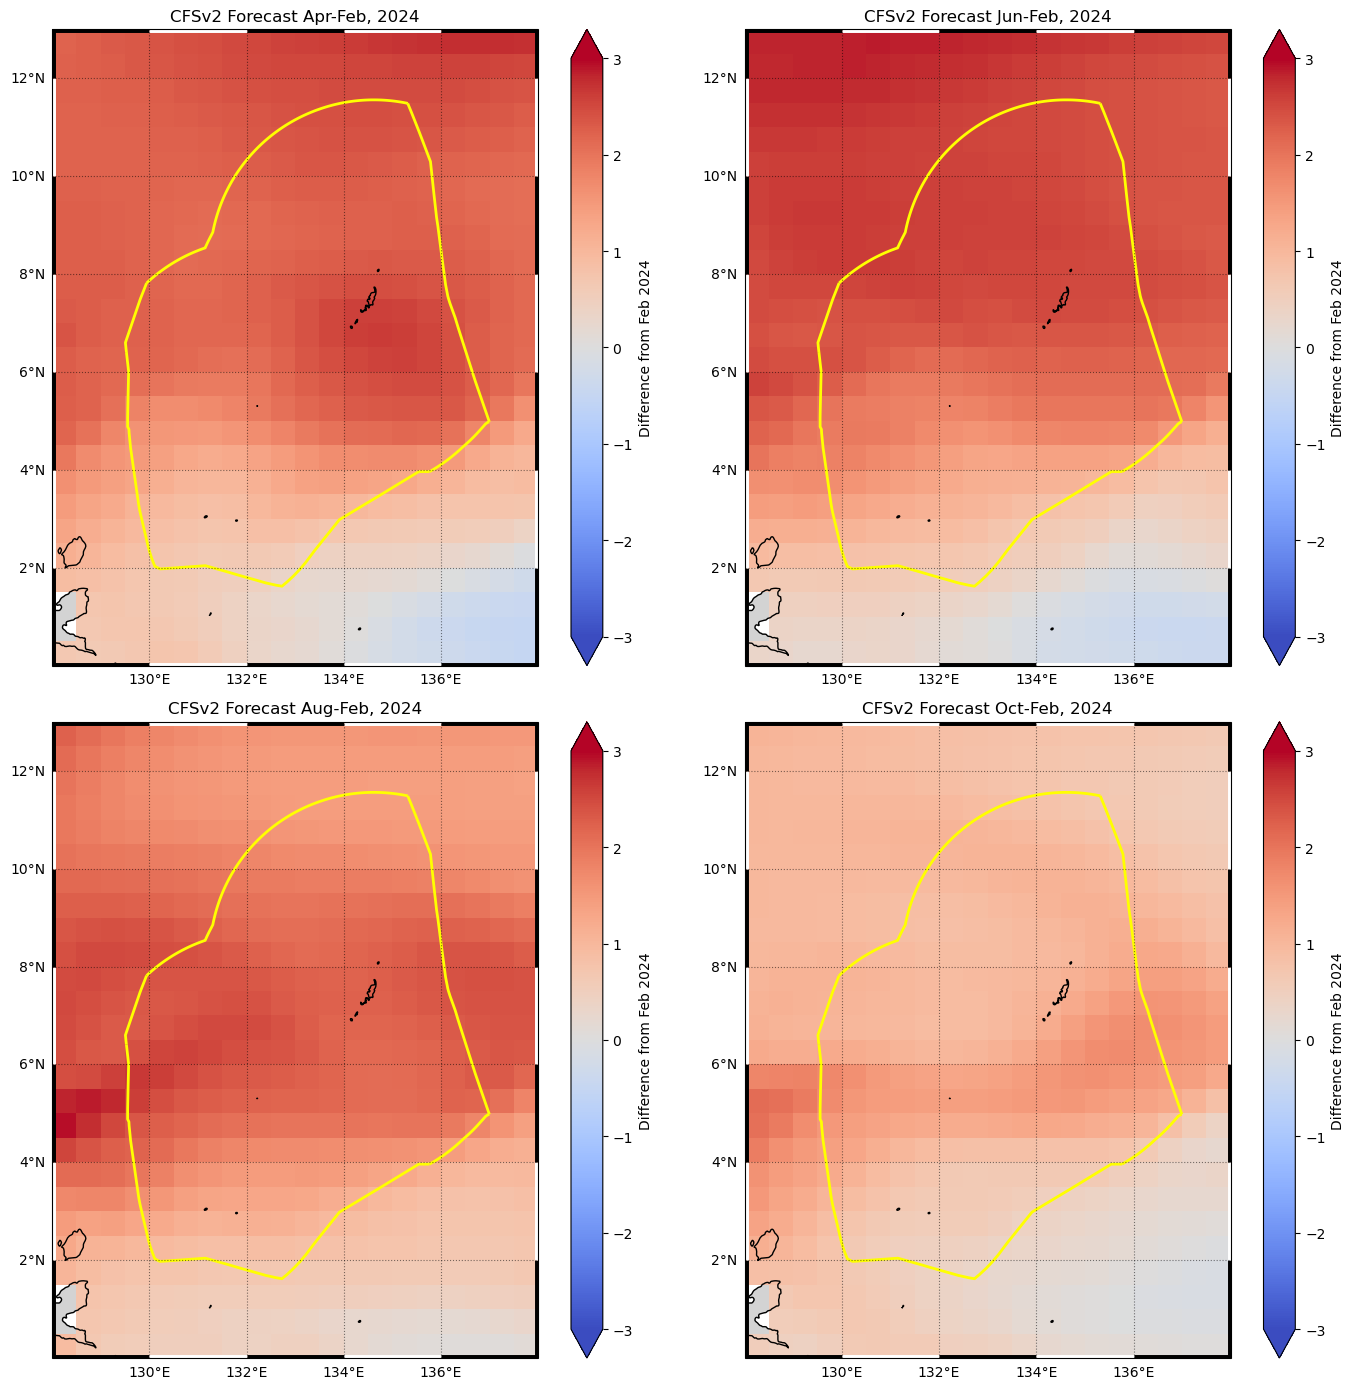

In [8]:
# make a four-panel plot

cmon = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

cmap = sns.color_palette("coolwarm", as_cmap=True)

fig, ax = plt.subplots( nrows=2, ncols=2, figsize=(14,14), subplot_kw={'projection': crs} )

k = 0
for i in range(2):
    for j in range (2):
        
        plot_title = 'CFSv2 Forecast ' + cmon[(k+1)*delta_file+ int(mod_mon)-1] + '-' + cmon[int(mod_mon)-1] + ', ' + mod_year
        
        sst[k,:,:].plot( ax=ax[i,j], transform=crs, robust=True,
                                   vmin=color_min, vmax=color_max, 
                                   cmap=cmap, add_colorbar=True, extend='both',
                                   cbar_kwargs={'label': 'Difference from Feb 2024'},)
        ax[i,j].set_xlim(lon_range)
        ax[i,j].set_ylim(lat_range)
        cmap = sns.color_palette("coolwarm", as_cmap=True)
        ax[i,j].coastlines()
        ax[i,j].add_feature(cfeature.LAND, color='lightgrey')      
        ax[i,j].set_title(plot_title)

        # Call the function to add the zebra frame
        plot_zebra_frame(ax[i,j], lw=5, segment_length=2.0, crs=crs)

        # add the EEZ
        shape_gpd.plot(ax=ax[i,j],color='yellow',transform=crs, linewidth=2);

        k += 1
plt.tight_layout()
plt.savefig('./images/temp_outlook_map.png')